# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [1]:
import pandas as pd
import os
import sklearn
from sklearn import linear_model
import sklearn.metrics
from sklearn import discriminant_analysis
from sklearn import ensemble
import matplotlib.pyplot as plt

In [42]:
print(sklearn.__version__)

1.5.1


In [2]:
df = pd.read_csv("../../data/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [3]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [4]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [5]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [20]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [22]:
import sklearn.discriminant_analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import sklearn.metrics
from sklearn.model_selection import ValidationCurveDisplay
import numpy as np

features = df[['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_day', 'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration']][:35000]
features_predict = df[['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_day', 'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration']][35000:]
want_to_predict = df['booking_complete'][:35000]
true_predict = df['booking_complete'][35000:]


# lm_model = linear_model.LinearRegression(positive=True)
# lm_model.fit(features, want_to_predict)
# print("LM MODEL:")
# for val1, val2 in zip(lm_model.feature_names_in_, lm_model.coef_):
#     print(val1, val2)

# print(f"Sum of LM values : {sum(lm_model.coef_)}")

# predicted_vals = lm_model.predict(features_predict)
# print(predicted_vals)

# print(sklearn.metrics.accuracy_score(true_predict, predicted_vals))


# ridge_model = linear_model.RidgeClassifier()
# ridge_model.fit(features, want_to_predict)
# print("RIDGE MODEL:")
# for val3, val4 in zip(ridge_model.feature_names_in_, ridge_model.coef_[0]):
#     print(val3, val4)

# print(f"Sum of Ridge values: {sum(ridge_model.coef_[0])}")

# predicted_ridge_vals = ridge_model.predict(features_predict)
# print(sklearn.metrics.accuracy_score(true_predict, predicted_ridge_vals))
# print(sklearn.metrics.classification_report(true_predict, predicted_ridge_vals, zero_division=0.0))

ridge_model_cv = linear_model.RidgeClassifierCV(store_cv_results=True)
ridge_model_cv.fit(features, want_to_predict)
print("Ridge Model with Leave One Out Cross Validation: ")
# for val5, val6 in zip(ridge_model_cv.feature_names_in_, ridge_model_cv.coef_[0]):
#     print(val5, val6)

# print(f"Sum of Ridge with CV: {sum(ridge_model_cv.coef_[0])}")

# predicted_ridgecv_vals = ridge_model_cv.predict(features_predict)
# print(f"Accuracy: {sklearn.metrics.accuracy_score(true_predict, predicted_ridgecv_vals)}")
# print(f"Balanced Accuracy: {sklearn.metrics.balanced_accuracy_score(true_predict, predicted_ridgecv_vals)}")
# print(sklearn.metrics.classification_report(true_predict, predicted_ridgecv_vals, zero_division=0.0))
# print(f"5-fold Cross-validation: {sklearn.model_selection.cross_val_score(ridge_model_cv, features, want_to_predict).mean()}")

# disp = sklearn.metrics.ConfusionMatrixDisplay.from_predictions(true_predict, predicted_ridgecv_vals, cmap=plt.cm.Blues, normalize="pred")
# disp.ax_.set_title("Normalized Ridge Classification Confusion Matrix")
# plt.show()

# ValidationCurveDisplay.from_estimator(linear_model.RidgeClassifierCV(), features, want_to_predict, param_name="alphas", param_range=np.linspace(-2, 2, 10))

ridge_importance_df = pd.DataFrame({
    'Features': features.columns,
    'Importance': ridge_model_cv.coef_
}).sort_values('Importance', ascending=False)
ridge_importance_df


Ridge Model with Leave One Out Cross Validation: 


,Features,Importance
5,wants_extra_baggage,0.063908
6,wants_preferred_seat,0.052799
7,wants_in_flight_meals,0.011834
0,num_passengers,0.001957
3,flight_hour,0.000164
4,flight_day,-0.000169
2,length_of_stay,-0.000303
1,purchase_lead,-0.000316
8,flight_duration,-0.052727


In [21]:
LDA_model = LinearDiscriminantAnalysis()
LDA_model.fit(features, want_to_predict)
print("Linear Discriminant Model:")
predicted_lda_vals = LDA_model.predict(features_predict)
# print(f"Accuracy: {sklearn.metrics.accuracy_score(true_predict, predicted_lda_vals)}")
# print(f"Balanced Accuracy: {sklearn.metrics.balanced_accuracy_score(true_predict, predicted_lda_vals)}")
# print(sklearn.metrics.classification_report(true_predict, predicted_lda_vals, zero_division=0.0))
# print(f"5-fold Cross-validation: {sklearn.model_selection.cross_val_score(LDA_model, features, want_to_predict).mean()}")

# disp = sklearn.metrics.ConfusionMatrixDisplay.from_predictions(true_predict, predicted_lda_vals, cmap=plt.cm.Blues, normalize="pred")
# disp.ax_.set_title("Normalized Linear Discriminant Model Confusion Matrix")
# plt.show()


coef_importance_df = pd.DataFrame({
    'Features': features.columns,
    'Importance': LDA_model.coef_[0]
}).sort_values('Importance', ascending=False)
coef_importance_df

Linear Discriminant Model:


,Features,Importance
5,wants_extra_baggage,0.290899
6,wants_preferred_seat,0.240312
7,wants_in_flight_meals,0.053727
0,num_passengers,0.008870
3,flight_hour,0.000747
4,flight_day,-0.000766
2,length_of_stay,-0.001376
1,purchase_lead,-0.001434
8,flight_duration,-0.239734


In [15]:
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier
import sklearn.inspection
from sklearn.model_selection import ValidationCurveDisplay
import numpy as np
GB_classifier = HistGradientBoostingClassifier()
GB_classifier.fit(features, want_to_predict)
print("Gradient Boosted Model")
predicted_gb_vals = GB_classifier.predict(features_predict)
# print(f"Accuracy: {sklearn.metrics.accuracy_score(true_predict, predicted_gb_vals)}")
# print(f"Balanced Accuracy: {sklearn.metrics.balanced_accuracy_score(true_predict, predicted_gb_vals)}")
# print(sklearn.metrics.classification_report(true_predict, predicted_gb_vals, zero_division=1.0))
# print(f"5-fold Cross-validation: {sklearn.model_selection.cross_val_score(GB_classifier, features, want_to_predict).mean()}")

# disp = sklearn.metrics.ConfusionMatrixDisplay.from_predictions(true_predict, predicted_gb_vals, cmap=plt.cm.Blues, normalize="pred")
# disp.ax_.set_title("Normalized Gradient Boosting Classifier Confusion Matrix")
plt.show()
# print(f"Confusion Matrix: {sklearn.metrics.confusion_matrix(true_predict, predicted_gb_vals)}")

perm_importance = sklearn.inspection.permutation_importance(GB_classifier, features_predict, true_predict, n_repeats=10, random_state=42)
perm_importance_df = pd.DataFrame({
    'Features': features.columns,
    'Importance': perm_importance['importances_mean'],
    'Importance_STD': perm_importance['importances_std']
}).sort_values('Importance', ascending=False)
perm_importance_df
# ValidationCurveDisplay.from_estimator(HistGradientBoostingClassifier(), features, want_to_predict, param_name="tol", param_range=np.logspace(-2, 2, 10))

Gradient Boosted Model


,Features,Importance,Importance_STD
3,flight_hour,6.666667e-06,0.000070
0,num_passengers,0.000000e+00,0.000000
2,length_of_stay,0.000000e+00,0.000000
4,flight_day,0.000000e+00,0.000000
8,flight_duration,-1.110223e-17,0.000079
5,wants_extra_baggage,-1.333333e-05,0.000027
7,wants_in_flight_meals,-2.666667e-05,0.000044
6,wants_preferred_seat,-6.666667e-05,0.000000
1,purchase_lead,-7.333333e-05,0.000055


Random Forest:


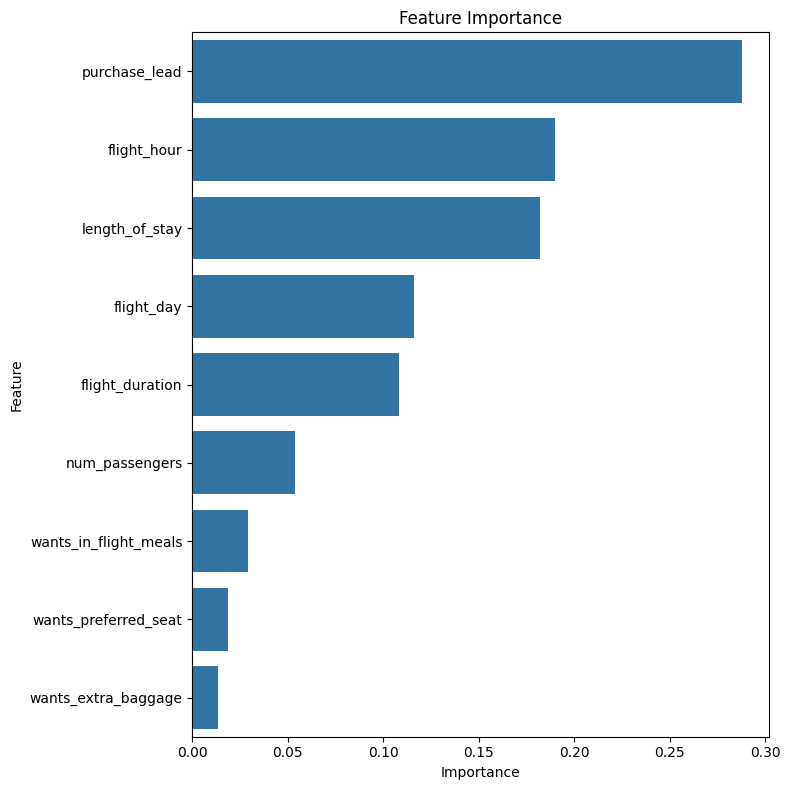

In [24]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.model_selection
RF_classifier = RandomForestClassifier()
RF_classifier.fit(features, want_to_predict)
print("Random Forest:")
predicted_rf_vals = RF_classifier.predict(features_predict)
# print(f"Accuracy: {sklearn.metrics.accuracy_score(true_predict, predicted_rf_vals)}")
# print(f"Balanced Accuracy: {sklearn.metrics.balanced_accuracy_score(true_predict, predicted_rf_vals)}")
# print(sklearn.metrics.classification_report(true_predict, predicted_rf_vals, zero_division=1.0))
# print(f"5-fold Cross-validation: {sklearn.model_selection.cross_val_score(RF_classifier, features, want_to_predict).mean()}")

# disp = sklearn.metrics.ConfusionMatrixDisplay.from_predictions(true_predict, predicted_rf_vals, cmap=plt.cm.Blues, normalize="pred")
# disp.ax_.set_title("Normalized Random Forest Classifier Confusion Matrix")
# plt.show()

importance_df = pd.DataFrame({
    'Feature': features.columns,
    'Importance': RF_classifier.feature_importances_
})

importance_df = importance_df.sort_values('Importance', ascending=False)
import seaborn as sns
plt.figure(figsize=(8,8))
sns.barplot(importance_df, x='Importance', y='Feature')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()